<a href="https://colab.research.google.com/github/chivy-debug/Detect_URL_Phishing_ML-DL/blob/main/RNN_phishing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 74s 145ms/step - accuracy: 0.6596 - loss: 0.5975 - val_accuracy: 0.7723 - val_loss: 0.4627
Epoch 2/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 79s 140ms/step - accuracy: 0.7650 - loss: 0.4779 - val_accuracy: 0.7934 - val_loss: 0.4252
Epoch 3/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 69s 143ms/step - accuracy: 0.7800 - loss: 0.4447 - val_accuracy: 0.8037 - val_loss: 0.4189
Epoch 4/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 70s 145ms/step - accuracy: 0.7941 - loss: 0.4355 - val_accuracy: 0.8158 - val_loss: 0.3868
Epoch 5/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 71s 147ms/step - accuracy: 0.8035 - loss: 0.4101 - val_accuracy: 0.8197 - val_loss: 0.3805
Epoch 6/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 71s 146ms/step - accuracy: 0.8144 - loss: 0.3933 - val_accuracy: 0.8266 - val_loss: 0.3680
Epoch 7/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 75s 154ms/step - accuracy: 0.8244 - loss: 0.3732 - val_accuracy: 0.8359 - val_loss: 0.3593
Epoch 8/10
486/486 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - accuracy: 0.8276 - loss: 0

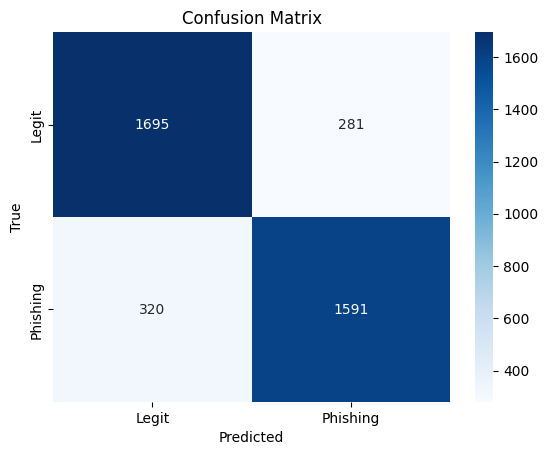

In [ ]:

# Import thư viện
import os
import numpy as np
import pandas as pd
import re
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout



# Tải dataset
df = pd.read_csv("/content/dataset_link_phishing.csv")

# Hàm rút trích đặc trưng từ URL
def extract_features(url):
    features = []

    if isinstance(url, str):
        # Phân tích URL
        parsed_url = urlparse(url)
        hostname = parsed_url.hostname if parsed_url.hostname else ''

        # 1. Độ dài của URL
        features.append(len(url))

        # 2. Độ dài của hostname
        features.append(len(hostname))

        # 3. Địa chỉ IP trong URL
        features.append(1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else 0)

        # 4-18. Tổng số ký tự đặc biệt trong URL (từ . đến $)
        special_chars = ['.', '-', '@', '?', '&', '=', '_', '~', '%',
                         '/', '*', ':', ',', ';', '$']
        for char in special_chars:
            features.append(len(re.findall(re.escape(char), url)))

        # 19. Số lần xuất hiện 'www'
        features.append(url.count('www'))

        # 20. Số lần xuất hiện '.com'
        features.append(url.count('.com'))

        # 21. HTTPS trong URL
        features.append(1 if 'https' in url else 0)

        # 22. Tỉ lệ ký tự số trong URL
        digits = sum(c.isdigit() for c in url)
        features.append(digits / len(url) if len(url) > 0 else 0)

        # 23. Tỉ lệ ký tự số trong hostname
        digits_in_host = sum(c.isdigit() for c in hostname)
        features.append(digits_in_host / len(hostname) if len(hostname) > 0 else 0)

        # 24. Số lượng subdomain
        subdomain_count = len(hostname.split('.')) - 2 if hostname else 0
        features.append(subdomain_count)

        # 25. Độ dài từ ngắn nhất trong hostname
        words_in_host = re.split(r'[\.-]', hostname)
        shortest_word_host = min([len(word) for word in words_in_host if word]) if words_in_host else 0
        features.append(shortest_word_host)

        # 26. Độ dài từ dài nhất trong hostname
        longest_word_host = max([len(word) for word in words_in_host if word]) if words_in_host else 0
        features.append(longest_word_host)

        # 27. Độ dài từ trung bình trong hostname
        avg_word_host = sum([len(word) for word in words_in_host]) / len(words_in_host) if words_in_host else 0
        features.append(avg_word_host)

        # 28. URL sử dụng tên miền rút gọn
        shorteners = ['bit.ly', 'goo.gl', 'tinyurl', 'ow.ly', 'is.gd']
        features.append(1 if any(shortener in url for shortener in shorteners) else 0)

        # 29. URL chứa địa chỉ email
        features.append(1 if re.search(r'[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}', url) else 0)

        # 30. Tỉ lệ ký tự chữ cái trong URL
        letters = sum(c.isalpha() for c in url)
        features.append(letters / len(url) if len(url) > 0 else 0)

        # 31. Số lượng từ trong URL
        words_in_url = len(re.findall(r'\w+', url))
        features.append(words_in_url)

        # 32. Độ dài của phần path
        path = parsed_url.path
        features.append(len(path))

        # 33. Số lượng ký tự trong path
        features.append(len(re.findall(r'\w+', path)))

        # 34. URL chứa domain đáng ngờ
        suspicious_domains = ['login', 'secure', 'account', 'verify', 'update',
                              'authentication', 'confirmation', 'validation',
                              'security-check', 'identity-verify']
        features.append(1 if any(domain in url for domain in suspicious_domains) else 0)

        # 35. Tỉ lệ ký tự số trong path
        digits_in_path = sum(c.isdigit() for c in path)
        features.append(digits_in_path / len(path) if len(path) > 0 else 0)

        # 36. Số lượng dấu '/' trong path
        features.append(path.count('/'))

        # 37. URL sử dụng TLD không phổ biến
        uncommon_tlds = ['xyz', 'top', 'click', 'online', 'icu', 'info',
                         'tk', 'ga', 'cf', 'ml', 'gq', 'loan', 'win',
                         'shop', 'site', 'us', 'pw']
        tld = hostname.split('.')[-1] if hostname else ''
        features.append(1 if tld in uncommon_tlds else 0)

        # 38. Số lượng tham số trong query
        query = parsed_url.query
        features.append(len(query.split('&')) if query else 0)

        # 39. Độ dài của phần query
        features.append(len(query) if query else 0)

        # 40. Query có chứa ký tự đặc biệt đáng ngờ không
        suspicious_query_chars = ['%20', '%22', '%27', '%3C', '%3E']
        features.append(1 if any(char in query for char in suspicious_query_chars) else 0)

        # 41. Tên miền chứa thương hiệu phổ biến
        trusted_domains = ['facebook.com', 'google.com', 'paypal.com', 'amazon.com',
                           'microsoft.com', 'apple.com', 'linkedin.com', 'twitter.com',
                           'netflix.com', 'bank.com', 'creditcard.com']
        features.append(1 if any(
            brand in hostname and hostname not in trusted_domains
            for brand in trusted_domains
        ) else 0)

        # 42. Tổng độ dài các subdomain
        subdomains = hostname.split('.')[:-2] if hostname else []
        features.append(sum(len(sub) for sub in subdomains))

        # 43. Subdomain đáng ngờ
        suspicious_subdomains = ['login', 'secure', 'account', 'auth', 'verify',
                                 'security', 'validation', 'confirm', 'admin']
        features.append(1 if any(sub in subdomains for sub in suspicious_subdomains) else 0)

        # 44. Tỉ lệ dấu '/' trong URL
        features.append(url.count('/') / len(url) if len(url) > 0 else 0)

        # 45. Path chứa từ khóa đáng ngờ
        suspicious_path_keywords = ['reset', 'confirm', 'admin', 'auth',
                                    'login', 'account', 'password',
                                    'recover', 'verification', 'update-credentials']
        features.append(1 if any(keyword in path for keyword in suspicious_path_keywords) else 0)

        # 46. Hostname chứa ký tự đặc biệt
        features.append(1 if any(char in hostname for char in ['_', '~', '$']) else 0)

        # 47. Tỉ lệ từ ngắn bất thường trong hostname
        invalid_words_in_host = [word for word in words_in_host if len(word) < 3]
        features.append(len(invalid_words_in_host) / len(words_in_host) if words_in_host else 0)

        # 48. Số lượng dấu '.' trong hostname
        features.append(hostname.count('.'))

        # 49. HTTPS trong hostname nhưng URL không bắt đầu bằng HTTPS
        features.append(1 if 'https' in hostname and not url.startswith('https') else 0)

        # 50. Độ dài của TLD
        features.append(len(tld))

        # 51. Query kết thúc bằng ký tự không hợp lệ
        features.append(1 if re.search(r'=[&]*$', query) else 0)

        # 52. Dấu hiệu chuyển hướng đáng ngờ
        features.append(1 if 'http://' in query or 'http://' in path else 0)

        # 53. Kiểm tra URL có chứa từ khóa không tin cậy trong phần path
        untrusted_path_keywords = ['fake', 'fraud', 'phishing', 'malware']
        features.append(1 if any(keyword in path for keyword in untrusted_path_keywords) else 0)

        # 54. Số lượng ký tự hoa trong URL (Kiểm tra xem URL có sử dụng nhiều chữ cái in hoa không)
        uppercase_count = sum(1 for c in url if c.isupper())
        features.append(uppercase_count)

        # 55. Tỉ lệ ký tự in hoa so với tổng ký tự trong URL
        features.append(uppercase_count / len(url) if len(url) > 0 else 0)

        # 56. Độ dài phần fragment (phần sau dấu '#')
        fragment = parsed_url.fragment
        features.append(len(fragment) if fragment else 0)

        # 57. URL có chứa từ khóa đáng ngờ trong fragment không
        suspicious_fragment_keywords = ['reset', 'confirm', 'secure', 'auth']
        features.append(1 if any(keyword in fragment for keyword in suspicious_fragment_keywords) else 0)

        # 58. Mã hóa đáng ngờ
        suspicious_encodings = ['%00', '%3A', '%2F', '%2E', '%5C']
        features.append(1 if any(encoding in url for encoding in suspicious_encodings) else 0)

        # 59. Ký tự lặp lại bất thường
        features.append(1 if re.search(r'\.\.\.\.|----', url) else 0)

        # 60. Tên miền quốc gia không phổ biến
        uncommon_ccTLDs = ['.tk', '.ga', '.cf', '.ml', '.gq']
        features.append(1 if any(tld.endswith(ccTLD) for ccTLD in uncommon_ccTLDs) else 0)

        # 61. Ký tự đặc biệt bất thường trong hostname
        special_chars_in_host = ['%', '$', '^', '&', '*', '(', ')', '=', '+', '#']
        features.append(sum(hostname.count(char) for char in special_chars_in_host))

        # 62. Từ khóa bảo mật trong bối cảnh đáng ngờ
        suspicious_security_keywords = ['secure', 'ssl', 'certified']
        features.append(1 if any(
            keyword in hostname and hostname not in trusted_domains
            for keyword in suspicious_security_keywords
        ) else 0)

        # 63. Độ dài URL bất thường
        features.append(1 if len(url) < 15 or len(url) > 200 else 0)

        # 64. Chuỗi giống mã trong hostname
        random_string_pattern = r'[a-zA-Z0-9]{10,}'
        features.append(1 if re.search(random_string_pattern, hostname) else 0)

    else:
        features = [0] * 64  # Nếu URL không hợp lệ, điền toàn bộ bằng 0

    return features


# Trích xuất các đặc trưng từ URL
df['features'] = df['url'].apply(extract_features)

# Chuẩn bị dữ liệu đầu vào
X = pd.DataFrame(df['features'].tolist())  # Chuyển đổi danh sách đặc trưng thành DataFrame
y = df['label']  # Nhãn 1 (phishing), 0 (legit)

# Chia dữ liệu thành tập huấn luyện và kiểm thử
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Chuẩn bị dữ liệu cho CNN (reshape thành (samples, timesteps, features))
X_train = np.array(X_train).reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = np.array(X_test).reshape(X_test.shape[0], X_test.shape[1], 1)

# Tạo lại mô hình với nhiều lớp LSTM và units lớn hơn
model = Sequential([
    LSTM(units=128, input_shape=(X_train.shape[1], 1), return_sequences=True),
    Dropout(0.3),
    LSTM(units=64, return_sequences=False),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Biên dịch mô hình
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Dự đoán
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Tính các chỉ số đánh giá
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.3f}')
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}')
print(f'F1-Score: {f1:.3f}')

# Báo cáo chi tiết
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

# Ma trận nhầm lẫn
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit', 'Phishing'], yticklabels=['Legit', 'Phishing'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
